# Solar Envelope

In this workshop we will learn how to compute the solar envelop of the building based on a voxelized building envelope.

## 0. Initialization
Importing all necessary libraries and specifying the inputs

In [1]:
import os
import topogenesis as tg
import pyvista as pv
import trimesh as tm
import numpy as np
from ladybug.sunpath import Sunpath

# convert mesh to pv_mesh
def tri_to_pv(tri_mesh):
    faces = np.pad(tri_mesh.faces, ((0, 0),(1,0)), 'constant', constant_values=3)
    pv_mesh = pv.PolyData(tri_mesh.vertices, faces)
    return pv_mesh

## 1. Import Meshes (context + envelope)

### 1.1. Load Meshes

In [3]:
envelope_path = os.path.relpath('../data/raw data/compulsory_envelope.obj')
context_path = os.path.relpath('../data/raw data/immediate_context.obj')

# load the mesh from file
envelope_mesh = tm.load(envelope_path)
context_mesh = tm.load(context_path)

# Check if the mesh is watertight
print(envelope_mesh.is_watertight)
print(context_mesh.is_watertight)

ValueError: string is not a file: ..\data\compulsory_envelope.obj

### 1.2. Visualize Meshes (with pyvista)

In [ ]:
# initiating the plotter
p = pv.Plotter(notebook=True)

# adding the meshes
p.add_mesh(tri_to_pv(envelope_mesh), color='#abd8ff')
p.add_mesh(tri_to_pv(context_mesh), color='#aaaaaa')

# plotting
# p.show()

<vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor(0x00000169501177F0) at 0x000001695A0C9880>

## 2. Import Lattice (envelope)

### 2.1. Load the Envelope Lattice

In [ ]:
# loading the lattice from csv
lattice_path = os.path.relpath('../data/voxelized_envelope.csv')
envelope_lattice = tg.lattice_from_csv(lattice_path)

### 2.2. Visualize the Context Mesh + Envelope Lattice

In [ ]:
# initiating the plotter
p = pv.Plotter()

# fast visualization of the lattice
envelope_lattice.fast_vis(p)

# adding the meshes
p.add_mesh(tri_to_pv(context_mesh), color='#aaaaaa')

# plotting
# p.show()

<vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor(0x00000169501171F0) at 0x000001695A0E0580>

## 3. Sun Vectors

### 3.1. Compute Sun Vectors

In [ ]:
# initiate sunpath
sp = Sunpath(longitude=4.3571, latitude=52.0116)

# define sun hours : A list of hours of the year for each sun vector
# there are 8760 hours in a year, so the following integers refer to specific hours throughout the year
hoys = []
sun_vectors = []
day_multiples = 90
# for each day of the year ...
for d in range(365):
    # if it is one of the multiples
    if d%day_multiples==0:
        # for each hour of the day ...
        for h in range(24):
            # compute the hoy (hour of the year)
            hoy = d*24 + h
            # compute the sun object
            sun = sp.calculate_sun_from_hoy(hoy)
            # extract the sun vector (the direction that the sun ray travels toward)
            sun_vector = sun.sun_vector.to_array()
            # evidently, if the Z component of sun vector is positive, 
            # the sun is under the horizon 
            if sun_vector[2] < 0.0:
                hoys.append(hoy)
                sun_vectors.append(sun_vector)
                
sun_vectors = np.array(sun_vectors)
# compute the rotation matrix 
Rz = tm.transformations.rotation_matrix(np.radians(36.324), [0,0,1])
# Rotate the sun vectors to match the site rotation
sun_vectors = tm.transform_points(sun_vectors, Rz)
print(sun_vectors.shape)

(56, 3)


In [ ]:
# Visualize the mesh using pyvista plotter
#######

# initiating the plotter
p = pv.Plotter(notebook=True)

# fast visualization of the lattice
envelope_lattice.fast_vis(p)

# adding the meshes
p.add_mesh(tri_to_pv(context_mesh), color='#aaaaaa')

# add the sun locations, color orange
p.add_points( - sun_vectors * 300, color='#ffa500')

# plotting
# p.show()

<vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor(0x0000016950115DF0) at 0x000001695A11E820>

## 4. Compute Intersection of Sun Rays with Context Mesh

### 4.1. Preparing the List of Ray Directions and Origins

In [ ]:
# constructing the sun direction from the sun vectors in a numpy array

converted_sun_vectors = sun_vectors.astype('float16')
sun_dirs = -np.array(converted_sun_vectors)

# exract the centroids of the envelope voxels
vox_cens = envelope_lattice.centroids
# next step we need to shoot in all of the sun directions from all of the voxels, todo so, we need repeat the sun direction for the number of voxels to construct the ray_dir (which is the list of all ray directions). We need to repeat the voxels for the 
ray_dir = []
ray_src = []
for v_cen in vox_cens:
    for s_dir in sun_dirs:
        ray_dir.append(s_dir)
        ray_src.append(v_cen)

ray_dir2 = []
ray_src2 = []
ray_dir2_index = []
for v_cen in vox_cens:
    for s_dir in converted_sun_vectors:
        ray_dir2.append(s_dir)
        ray_src2.append(v_cen)
# converting the list of directions and sources to numpy array
ray_dir = np.array(ray_dir)
ray_src = np.array(ray_src)
ray_dir2 = np.array(ray_dir2)
ray_src2 = np.array(ray_src2)

"""
# Further info: this is the vectorised version of nested for loops
ray_dir = np.tile(sun_dirs, [len(vox_cens),1])
ray_src = np.tile(vox_cens, [1, len(sun_dirs)]).reshape(-1, 3)
"""

print("number of voxels to shoot rays from :",vox_cens.shape)
print("number of rays per each voxel :",sun_dirs.shape)
print("number of rays to be shooted :",ray_src.shape)
print(ray_src2.shape)

number of voxels to shoot rays from : (300, 3)
number of rays per each voxel : (56, 3)
number of rays to be shooted : (16800, 3)
(16800, 3)


### 4.2. Computing the Intersection

In [ ]:
# computing the intersections of rays with the context mesh
tri_id, ray_id = context_mesh.ray.intersects_id(ray_origins=ray_src, ray_directions=ray_dir, multiple_hits=False)

In [ ]:
# computing the intersections of the inverted rays with the context mesh
tri_id2, ray_id2 = context_mesh.ray.intersects_id(ray_origins=ray_src2, ray_directions=ray_dir2, multiple_hits=False)

## 5. Aggregate Simulation Result in the Sun Access Lattice

### 5.1. Compute the percentage of time that each voxel sees the sun

In [ ]:
# initializing the hits list full of zeros
hits = [0]*len(ray_dir)
hits2 = [0]*len(ray_dir2)

# setting the rays that had an intersection to 1
for id in ray_id:
    hits[id] = 1 # sun access
for id2 in ray_id2:
    hits2[id2] = 1 # sun access

# sun_count = len(sun_dirs)
# vox_count = len(vox_cens)
# # initiating the list of ratio
# vox_sun_acc = []
# # iterate over the voxels
# for v_id in range(vox_count):
#     # counter for the intersection
#     int_count = 0
#     # iterate over the sun rays
#     for s_id in range(sun_count):
#         # computing the ray id from voxel id and sun id
#         r_id = v_id * sun_count + s_id

#         # summing the intersections
#         int_count += hits[r_id]
    
#     # computing the percentage of the rays that DID NOT have 
#     # an intersection (aka could see the sun)
#     sun_access = 1.0 - int_count/sun_count

#     # add the ratio to list
#     vox_sun_acc.append(sun_access)

# initializing the hits list full of zeros

# setting the rays that had an intersection to 1
    

# rays that did not intersect get set to 0
# hcounter = 0
# for i in ray_dir2_index:
#     if i == 1:
#         hits3.append(hits2[hcounter])
#         hcounter += 1
#     else:
#         hits3.append(0)

sun_count=len(sun_dirs)
vox_count=len(vox_cens)

vox_sun_acc = []
vox_sun_blockage = []

for v_id in range(vox_count):
    int_count = 0 # sun access
    int_count2 = 0 #sun block
    for s_id in range(sun_count):
        r_id = s_id + v_id * sun_count

        # summing intersections
        int_count += hits[r_id]
        if hits[r_id]==0:
            int_count2 += hits2[r_id]

    # computing the percentage of raysthat did not have an intersection aka could see the sun
    sun_access = 1.0 - int_count/sun_count 
    sun_blockage = 1.0 - int_count2/sun_count

    #add the ratio to the list
    vox_sun_acc.append(sun_access)
    vox_sun_blockage.append(sun_blockage)

vox_sun_acc = np.array(vox_sun_acc)
vox_sun_blockage = np.array(vox_sun_blockage)


### 5.2. Store sun access information in a Lattice

In [ ]:
# getting the condition of all voxels: are they inside the envelop or not
env_all_vox = envelope_lattice.flatten()

# all voxels sun access
all_vox_sun_acc = []

# v_id: voxel id in the list of only interior voxels
v_id = 0

# for all the voxels, place the interiority condition of each voxel in "vox_in"
for vox_in in env_all_vox:
    # if the voxel was outside...
    if vox_in == True:
        # read its value of sun access and append it to the list of all voxel sun access
        all_vox_sun_acc.append(vox_sun_acc[v_id])
        # add one to the voxel id so the next time we read the next voxel
        v_id += 1
    # if the voxel was not inside... 
    else:
        # add 0.0 for its sun access
        all_vox_sun_acc.append(0.0)

# convert to array
sunacc_array = np.array(all_vox_sun_acc)

"""
# Further info: this is the vectorised version of nested for loops
env_all_vox_id = envelope_lattice.indices.flatten()
env_all_vox = envelope_lattice.flatten()
env_in_vox_id = env_all_vox_id[env_all_vox]
sunacc_array = np.full(env_all_vox.shape, 0.0)
sunacc_array[env_in_vox_id] = vox_sun_acc
"""

# reshape to lattice shape
sunacc_array = sunacc_array.reshape(envelope_lattice.shape)

# convert to lattice
sunacc_lattice = tg.to_lattice(sunacc_array, envelope_lattice)


print(sunacc_lattice.shape)

(16, 9, 5)


### 5.3. Visualize the sun access lattice

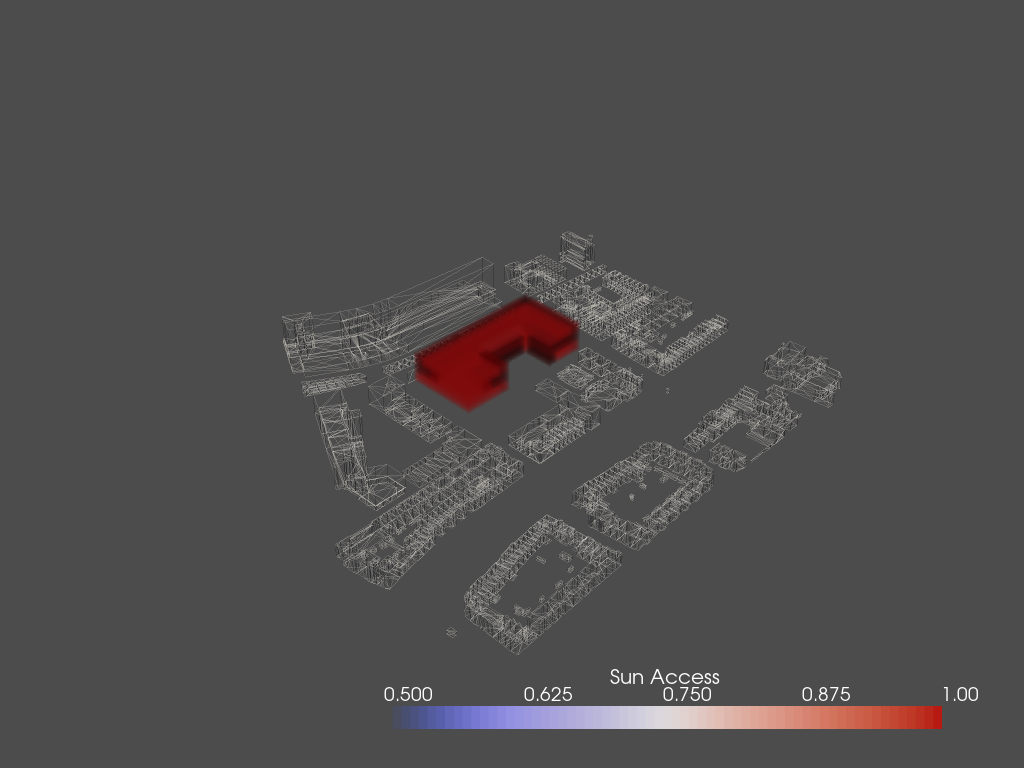

[(785.6075686833789, 708.1911636833788, 743.2184808333789),
 (65.08283250000001, -12.333572500000002, 22.69374465),
 (0.0, 0.0, 1.0)]

In [ ]:
# initiating the plotter
p = pv.Plotter(notebook=True)

l = sunacc_lattice
# remapping
l = 250 * (l - l.min()) / l.max()

# Create the spatial reference
grid = pv.UniformGrid()

# Set the grid dimensions: shape because we want to inject our values
grid.dimensions = l.shape
# The bottom left corner of the data set
grid.origin = l.minbound
# These are the cell sizes along each axis
grid.spacing = l.unit

# Add the data values to the cell data
grid.point_arrays["Sun Access"] = l.flatten(order="F")  # Flatten the Lattice

# adding the meshes
p.add_mesh(tri_to_pv(context_mesh), opacity=0.1, style='wireframe')
    
# adding the volume
opacity = np.array([0,0.6,0.6,0.6,0.6,0.6,0.6])*1.5
p.add_volume(grid, cmap="coolwarm", clim=[0.5, 1.0],opacity=opacity, shade=True)

# plotting
p.show()

## 6. Save Sun Access Lattice into a CSV

In [ ]:
# save the sun access latice to csv

csv_path = os.path.relpath('../data/sun_access.csv')
sunacc_lattice.to_csv(csv_path)

### Credits

In [ ]:
__author__ = "Shervin Azadi and Pirouz Nourian"
__license__ = "MIT"
__version__ = "1.0"
__url__ = "https://github.com/shervinazadi/spatial_computing_workshops"
__summary__ = "Spatial Computing Design Studio Workshop on Solar Envelope"